In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.1
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)

## Pairwise DMG

In [3]:
pairwise_dmg = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusterMethylMarker/ExcSubTypePairwiseMarker/TotalPairwiseMarker.msg'
)
pair_gene_counts = pairwise_dmg.groupby(['cluster_from', 'cluster_to']).apply(lambda i: i.shape[0])
pair_gene_counts.index = pair_gene_counts.index.map(lambda i: tuple(sorted(i)))
final_gene_counts = pair_gene_counts.groupby(pair_gene_counts.index).sum()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
gene_count = pd.DataFrame([
    final_gene_counts.index.map(lambda i: i[0]),
    final_gene_counts.index.map(lambda i: i[1]), final_gene_counts.values
],
                                index=['a', 'b', 'count'
                                       ]).T.set_index(['a', 'b'
                                                       ])['count']
gene_count_r = pd.Series(gene_count.values, index=gene_count.index.map(lambda i: i[::-1]))
gene_count_table = pd.concat([gene_count, gene_count_r]).unstack().fillna(0)

In [5]:
# order by dendrogram
cluster_order = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Exc.dendrogram.lib'
)['ivl']

name_map = {
    i.replace(' ', '.').replace('-', '.'): i
    for i in gene_count_table.index
}
cluster_order = [name_map[i] for i in cluster_order]

gene_count_table = gene_count_table.reindex(index=cluster_order, columns=cluster_order)

In [6]:
mask = np.zeros_like(gene_count_table)
mask[np.triu_indices_from(mask)] = True

In [7]:
counts = gene_count_table.unstack()
counts = counts[counts > 0]
min_gene, max_gene = counts.min(), counts.max()

## Cluster Gene mCH Level

In [8]:
subtype_rate = xr.open_dataset(
    '/home/hanliu/project/mouse_rostral_brain/study/mCClustermCLevel/SubType.geneslop2k.mcds'
)['gene_cluster_da_rate'].sel(mc_type='CHN').to_pandas().T
subtype_rate.columns = subtype_rate.columns.str.replace(' ', '_')
subtype_rate.head()

SubType,MGE-Sst_Rxra,CA3_Cadm2,CA1_Chrm3,CA3-St18_Tead1,Unc5c_Unc5c,Gfra1_Gfra1,ODC_odc-small,PC_pc-all,ODC_odc-large,ANP_anp-dg,...,D1L-PAL_Plcxd3,PAL-Inh_Onecut2,LSX-Inh_Foxp2,LSX-Inh_Enox1,MSN-D1_Outlier,LSX-Inh_Dock10,LSX-Inh_Nxph1,LSX-Inh_Zeb2,LSX-Inh_Lats2,PT-L5_Outlier
geneslop2k,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000102693.1,0.036028,0.033156,0.023127,0.027134,0.024149,0.030705,0.007401,0.004408,0.006504,0.005405,...,0.011507,0.042900,0.028670,0.025057,0.026316,0.022981,0.022370,0.019700,0.018092,0.018018
ENSMUSG00000064842.1,0.043546,0.029851,0.024722,0.027768,0.030352,0.039891,0.009691,0.004859,0.009342,0.006471,...,0.014913,0.049733,0.032969,0.029144,NaN,0.028612,0.030037,0.026626,0.031396,0.000000
ENSMUSG00000051951.5,0.011518,0.009630,0.008233,0.017092,0.011801,0.014484,0.018628,0.004790,0.015895,0.005185,...,0.012604,0.023654,0.026305,0.021451,0.013525,0.024743,0.022012,0.025300,0.021889,0.022814
ENSMUSG00000102851.1,0.012793,0.008696,0.008266,0.013822,0.010621,0.012788,0.013043,0.005251,0.013161,0.004871,...,0.012873,0.025467,0.030113,0.022554,0.000000,0.024056,0.025327,0.024327,0.015444,NaN
ENSMUSG00000103377.1,0.008664,0.009502,0.009479,0.024804,0.010696,0.016256,0.049207,0.004797,0.038580,0.005653,...,0.014659,0.025282,0.034705,0.026059,0.000000,0.032258,0.030009,0.032695,0.029836,0.015038


In [9]:
example_pair = ['CA1 Chrm3', 'CA3 Cadm2']

related_genes = pairwise_dmg[pairwise_dmg['cluster_from'].isin(example_pair)
                             & pairwise_dmg['cluster_to'].isin(example_pair)]
use_rate = subtype_rate.loc[related_genes['gene_id'], [i.replace(' ', '_') for i in example_pair]]
gene_delta = (use_rate.iloc[:, 0] - use_rate.iloc[:, 1]).sort_values(ascending=False)

use_rate_up = use_rate.loc[gene_delta[gene_delta > 0.01].index]
use_rate_low = use_rate.loc[gene_delta[gene_delta < -0.01].index]


## Plot

(15, 11)


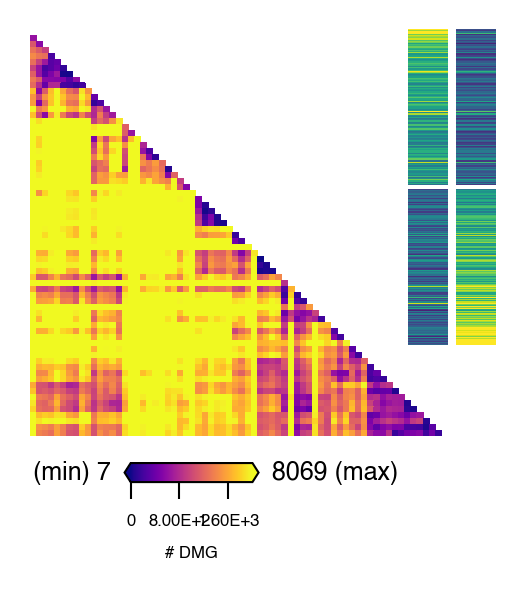

In [12]:
fig = plt.figure(figsize=(2, 2), dpi=300)

gs = fig.add_gridspec(20, 10)

ax_heatmap = fig.add_subplot(gs[:18, :9])
ax_cbar = fig.add_subplot(gs[-1, 2:5])
ax_up_left = fig.add_subplot(gs[0:7, 8])
ax_up_right = fig.add_subplot(gs[0:7, 9])
ax_low_left = fig.add_subplot(gs[7:14, 8])
ax_low_right = fig.add_subplot(gs[7:14, 9])

ax = ax_heatmap
sns.heatmap(gene_count_table.fillna(0),
            ax=ax,
            vmin=0,
            vmax=2000,
            cmap='plasma',
            mask=mask,
            cbar=None)
ax.set(xticks=[], yticks=[], xlabel='', ylabel='')

ax = ax_cbar
from ALLCools.plot.color import plot_colorbar
plot_colorbar(ax,
              cmap='plasma',
              hue_norm=(0, 2000),
              cnorm=None,
              label='# DMG',
              orientation='horizontal',
              labelsize=4,
              linewidth=0.5)
ax.text(-0.05,
        0.5,
        f'(min) {min_gene} ',
        fontsize=labelsize,
        ha='right',
        va='center',
        transform=ax.transAxes,
        clip_on=False)
ax.text(1.05,
        0.5,
        f' {max_gene} (max)',
        fontsize=labelsize,
        ha='left',
        va='center',
        transform=ax.transAxes,
        clip_on=False)
example_loc = gene_count_table.index.get_loc(example_pair[1]), gene_count_table.columns.get_loc(example_pair[0])
print(example_loc)

ax = ax_up_left
ax.imshow(use_rate_up.iloc[:, 0].values[:, None],
          aspect='auto',
          cmap='viridis',
          vmin=0,
          vmax=0.05)
ax.axis('off')
ax = ax_up_right
ax.imshow(use_rate_up.iloc[:, 1].values[:, None],
          aspect='auto',
          cmap='viridis',
          vmin=0,
          vmax=0.05)
ax.axis('off')
ax = ax_low_left
ax.imshow(use_rate_low.iloc[:, 0].values[:, None],
          aspect='auto',
          cmap='viridis',
          vmin=0,
          vmax=0.05)
ax.axis('off')
ax = ax_low_right
ax.imshow(use_rate_low.iloc[:, 1].values[:, None],
          aspect='auto',
          cmap='viridis',
          vmin=0,
          vmax=0.05)
ax.axis('off')

fig.savefig('PairwiseDMG.pdf')

In [13]:
use_rate_up.shape[0], use_rate_low.shape[0]

(136, 693)

In [15]:
(gene_delta > 0).sum()

484

In [16]:
(gene_delta < 0).sum()

740